In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn import random_projection, preprocessing, metrics
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.metrics import homogeneity_score
from ucimlrepo import fetch_ucirepo 
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold import MDS
from typing import Tuple
import matlab.engine
np.random.seed(1234)

In [3]:
def load_rice_x_y() -> Tuple[pd.DataFrame, pd.DataFrame]:
    try:
        rice = load_rice_file()
        X = rice.drop(['Class'], inplace=False, axis=1)
        y = pd.DataFrame(rice['Class'])
        return X, y
    except:
        rice = fetch_ucirepo(id=545) 
        X = rice.data.features 
        y = rice.data.targets
        y.loc[:, 'Class'] = y.loc[:, 'Class'].apply(lambda x: int(x == 'Cammeo'))
        pd.concat([y['Class'], X], axis=1).to_csv('rice.csv', index=False)
    return X, y

def load_rice() -> pd.DataFrame:
    try:
        rice = load_rice_file()
        return rice
    except:
        rice = fetch_ucirepo(id=545) 
        X = rice.data.features 
        y = rice.data.targets 
        y.loc[:, 'Class'] = y.loc[:, 'Class'].apply(lambda x: int(x == 'Cammeo'))
        df = pd.concat([y['Class'], X], axis=1)
        df.to_csv('rice.csv', index=False)
        return df

def load_rice_file(filename='rice.csv'):
    rice = pd.read_csv(filename)
    return rice


load_rice()

,Class,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,1,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,1,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,1,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,1,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
...,...,...,...,...,...,...,...,...
3805,0,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012
3806,0,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279
3807,0,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739
3808,0,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064


In [12]:
load_rice()

In [130]:
#EM for rice
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = load_rice_x_y()
X = (X - X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
for k in range(2, 16):
    em = eng.mixGaussEm(X_train, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train['Class'], labels)
    silhouette = metrics.silhouette_score(X_train.T, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])



EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 


In [131]:
X, y = load_rice_x_y()
X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
spectral_homogeneity = []
spectral_silhouette = []
for n in range(2, 16):
    labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X_train)
    spectral_homogeneity.append(homogeneity_score(y_train['Class'], labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

Text(0, 0.5, 'Score')

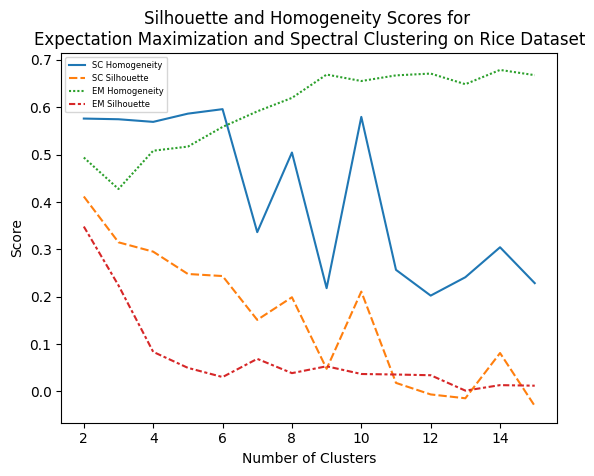

In [147]:
initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['SC Homogeneity'] = spectral_homogeneity
initial_clustering_scores['SC Silhouette'] = spectral_silhouette
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=6)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Rice Dataset')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')
#pd.DataFrame([spectral_scores[:, 0], spectral_scores[:, 1], em_scores[:, 0], em_scores[:, 1]], columns=["SC Homogeneity", "SC Silhoutte", "EM Homogeneity", "EM Silhoutte"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


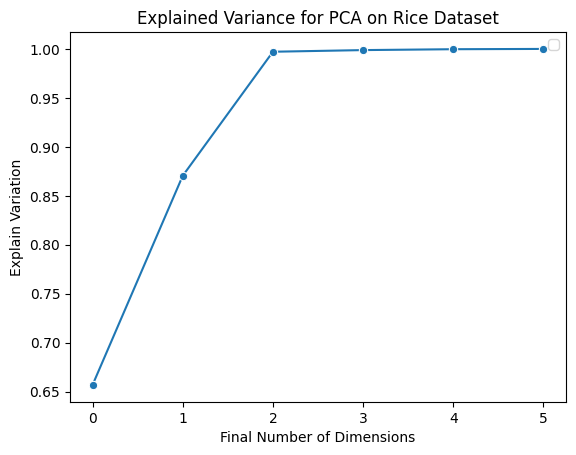

<Figure size 640x480 with 0 Axes>

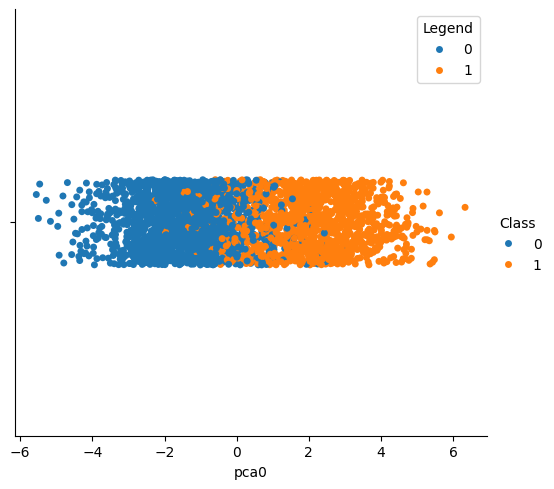

<Figure size 640x480 with 0 Axes>

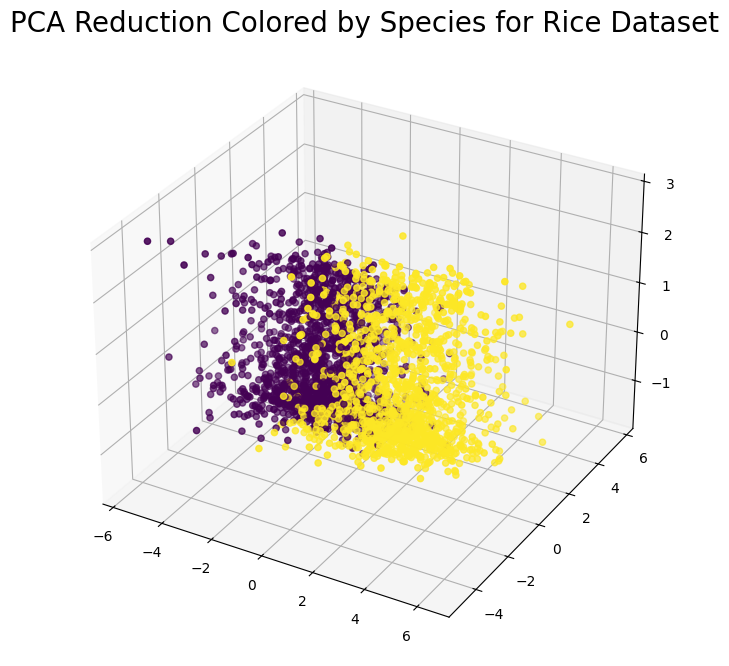

0.9970614350997837


In [8]:
#dimensionality reduction
X, y = load_rice_x_y()

explained_var_ratio = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_centered = preprocessing.StandardScaler().fit_transform(X_train)
for i in range(1, 7):
    pca = PCA(n_components=i, whiten=True)
    pca.fit(X_centered)
    explained_var_ratio.append(sum(pca.explained_variance_ratio_))






explained_var_ratio_df = pd.DataFrame(explained_var_ratio, index=range(1, 7), columns=['Explained Variation'])
sns.lineplot(explained_var_ratio, marker='o')
plt.ylabel('Explain Variation')
plt.xlabel('Final Number of Dimensions')
plt.title('Explained Variance for PCA on Rice Dataset')
plt.legend()
plt.show()
plt.clf()



pca = PCA(n_components=3)
rice_pca_df = pd.DataFrame(pca.fit_transform(X_centered), columns=pca.get_feature_names_out())
rice_pca_df['Class'] = y_train.values
g = sns.catplot(rice_pca_df, x='pca0', hue='Class')

plt.legend(title='Legend')
plt.show()
plt.clf()
rice_pca_df.to_csv('rice_pca.csv', index=False)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rice_pca_df['pca0'], rice_pca_df['pca1'], rice_pca_df['pca2'], c=rice_pca_df['Class'], cmap='viridis', marker='o')
plt.title('PCA Reduction Colored by Species for Rice Dataset', fontsize=20)
plt.show()


print(explained_var_ratio[2])

Text(0.5, 1.0, 'Distribution of Normalized Variables for Rice Dataset')

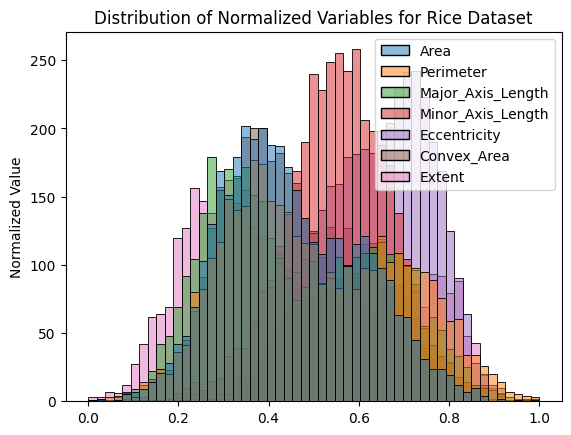

In [191]:
df = load_rice().drop('Class', axis=1, inplace=False)
df_norm = preprocessing.MinMaxScaler().fit_transform(df)
df = pd.DataFrame(df_norm, index=df.index, columns=df.columns)
g = sns.histplot(df)
g.set_ylabel('Normalized Value')
g.set_title('Distribution of Normalized Variables for Rice Dataset')

2 Dimensions: [-21.80353915   4.44967859]


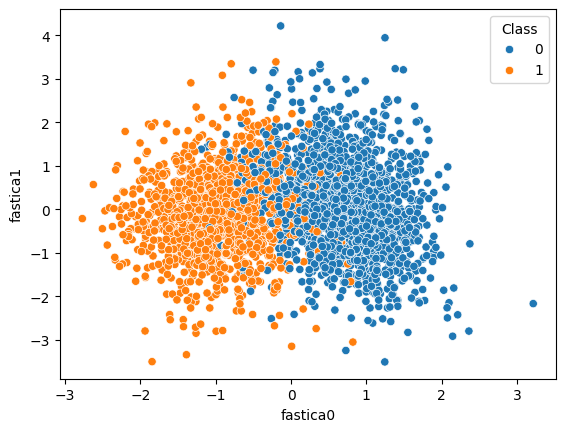

<Figure size 640x480 with 0 Axes>

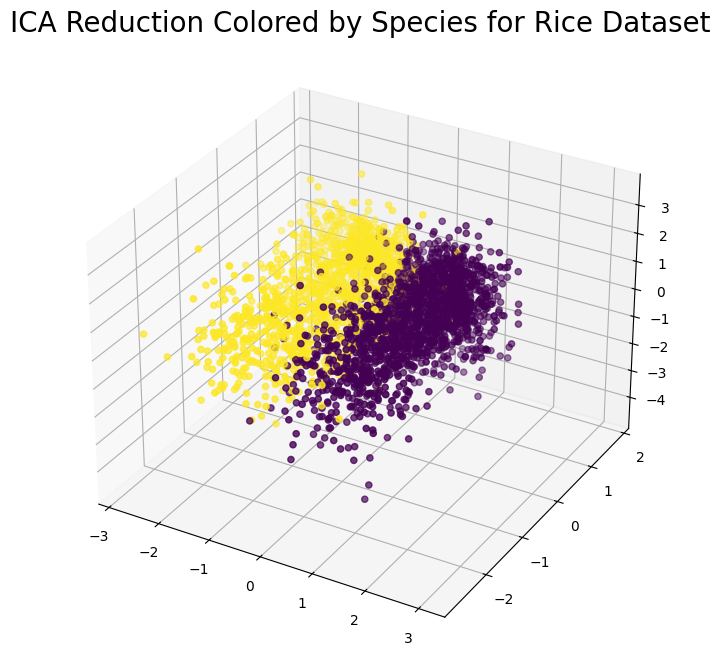

3 Dimensions: [-23.92268337 -25.59110575   4.88028844]


In [214]:


ica = FastICA(random_state=123, n_components=2, whiten='unit-variance')
rice_ica_df = pd.DataFrame(ica.fit_transform(X_centered), columns=ica.get_feature_names_out())
rice_ica_df['Class'] = y_train.values

sns.scatterplot(rice_ica_df, x='fastica0', y='fastica1', hue='Class')
res = stats.kurtosistest(rice_ica_df.drop('Class', axis=1, inplace=False))
print(f'2 Dimensions: {res.statistic}')

plt.show()
plt.clf()


ica_d3 = FastICA(random_state=123, n_components=3, whiten='unit-variance')
rice_ica_df_d3 = pd.DataFrame(ica_d3.fit_transform(X_centered), columns=ica_d3.get_feature_names_out())
rice_ica_df_d3['Class'] = y_train.values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rice_ica_df_d3['fastica0'], rice_ica_df_d3['fastica1'], rice_ica_df_d3['fastica2'], c=rice_ica_df_d3['Class'], cmap='viridis', marker='o')
plt.title('ICA Reduction Colored by Species for Rice Dataset', fontsize=20)
plt.show()
res = stats.kurtosistest(rice_ica_df_d3.drop('Class', axis=1, inplace=False))
print(f'3 Dimensions: {res.statistic}')

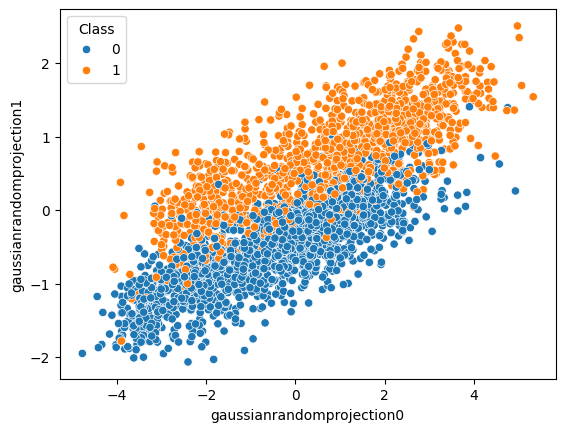

<Figure size 640x480 with 0 Axes>

In [19]:

rice_rp = random_projection.GaussianRandomProjection(n_components=2, random_state=123)

rice_rp_df = pd.DataFrame(rice_rp.fit_transform(X_centered), columns=rice_rp.get_feature_names_out())
rice_rp_df['Class'] = y_train.values


sns.scatterplot(rice_rp_df, x='gaussianrandomprojection0', y='gaussianrandomprojection1', hue='Class')
plt.show()
plt.clf()




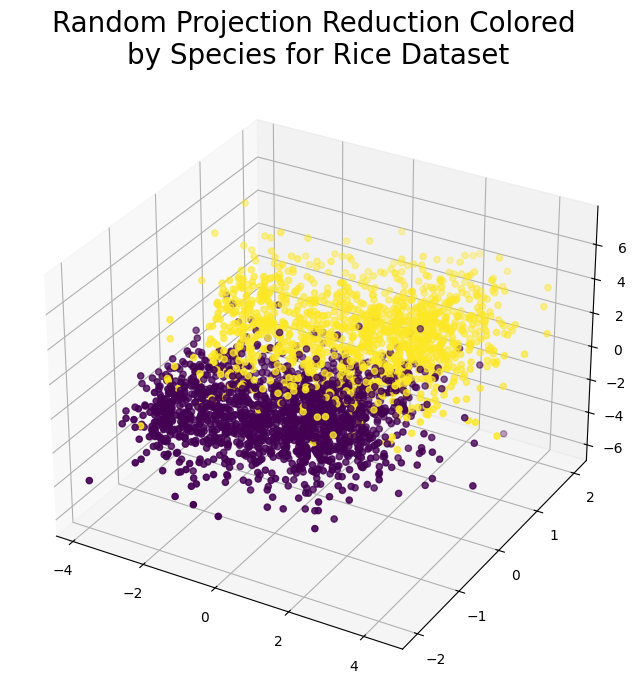

In [217]:
rice_rp_d3 = random_projection.GaussianRandomProjection(n_components=3, random_state=123)

rice_rp_df_d3 = pd.DataFrame(rice_rp_d3.fit_transform(X_centered), columns=rice_rp_d3.get_feature_names_out())
rice_rp_df_d3['Class'] = y_train.values

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rice_rp_df_d3['gaussianrandomprojection0'], rice_rp_df_d3['gaussianrandomprojection1'], rice_rp_df_d3['gaussianrandomprojection2'], c=rice_rp_df_d3['Class'], cmap='viridis', marker='o')
plt.title('Random Projection Reduction Colored \nby Species for Rice Dataset', fontsize=20)
plt.show()

In [21]:
stress_score = []

for i in range(2, 7):
    rice_mds = MDS(n_components=i, n_jobs=-1)
    rice_mds_data = rice_mds.fit_transform(X_centered)
    stress_score.append(rice_mds.stress_)


In [9]:
#3 dim rice mds
rice_mds_d3 = MDS(n_components=3, n_jobs=-1)
rice_mds_out_d3 = rice_mds_d3.fit_transform(X_centered)
rice_mds_df_d3 = pd.DataFrame(rice_mds_out_d3, columns=['mds0', 'mds1', 'mds2'])
rice_mds_df_d3['Class'] = y_train.values
rice_mds_df_d3.to_csv('rice_mds.csv', index=False)




KeyboardInterrupt: 

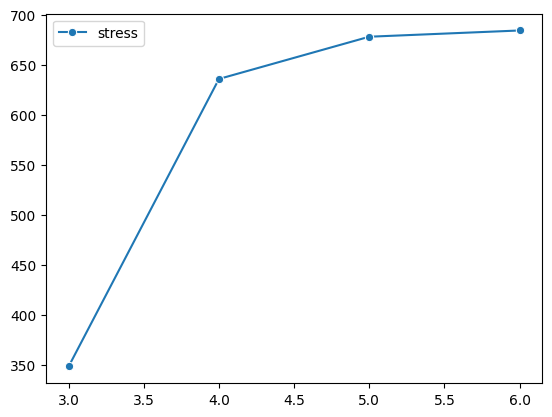

<Figure size 640x480 with 0 Axes>

In [24]:
stress_score_df = pd.DataFrame([round(s, 3) for s in stress_score],index=[2, 3, 4, 5, 6], columns=['stress'])
sns.lineplot(stress_score_df.iloc[1:], marker='o')
plt.show()
plt.clf()





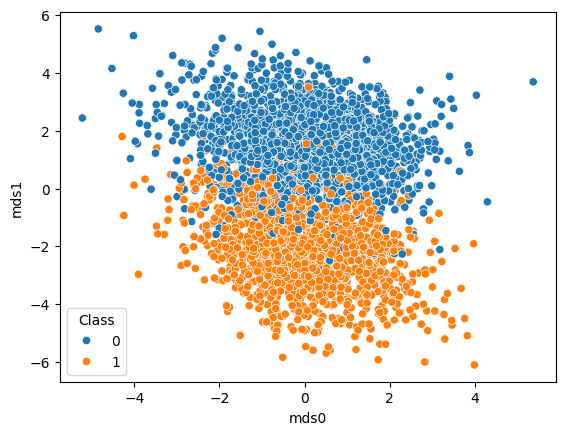

<Figure size 640x480 with 0 Axes>

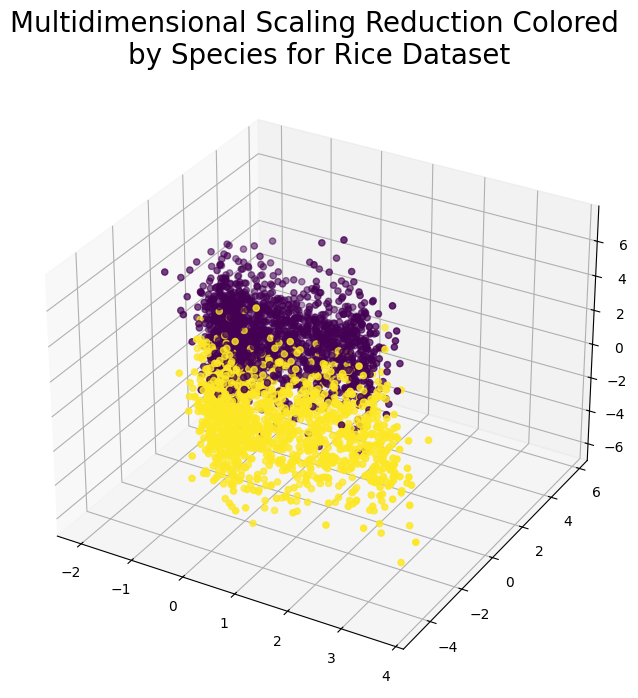

In [218]:
sns.scatterplot(rice_mds_df, x='mds0', y='mds1', hue='Class')
plt.show()
plt.clf()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rice_mds_df_d3['mds0'], rice_mds_df_d3['mds1'], rice_mds_df_d3['mds2'], c=rice_mds_df['Class'], cmap='viridis', marker='o')
plt.title('Multidimensional Scaling Reduction Colored \nby Species for Rice Dataset', fontsize=20)

plt.show()

EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
    Homogeneity  Silhouette
0      0.544395    0.624738
1      0.082617    0.307554
2   

<Axes: >

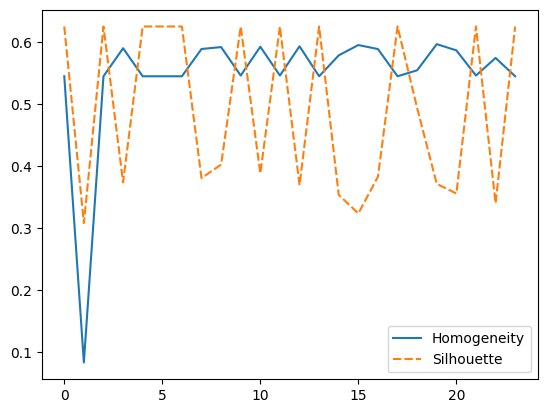

In [90]:
#revisit clustering

#EM
#EM PCA for rice
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = rice_pca_df.drop('Class', inplace=False, axis=1).values.transpose().astype('float64'), rice_pca_df['Class'] 
score = []
max_llh = []
for k in range(2, 26):
    em = eng.mixGaussEm(X, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y.values, labels)
    silhouette = metrics.silhouette_score(X.transpose(), labels)
    score.append((homogeneity, silhouette))
    max_llh.append(llh)

score_k = pd.DataFrame(score, columns=['Homogeneity', 'Silhouette'])
max_llh = np.array(max_llh)
print(score_k)
sns.lineplot(score_k)

<Axes: >

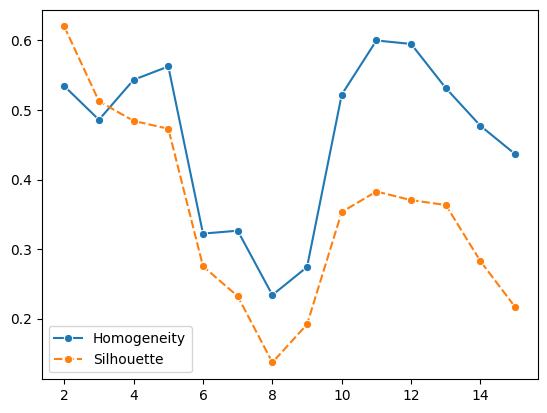

In [89]:
X, y = rice_pca_df.drop('Class', inplace=False, axis=1), rice_pca_df['Class'] 

spectral_scores = []
for n in range(2, 16):
    labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X)
    homogeneity = homogeneity_score(y.values, labels)
    silhouette = metrics.silhouette_score(X, labels)
    spectral_scores.append((homogeneity, silhouette))


spectral_scores_df = pd.DataFrame(spectral_scores, index = range(2, 16), columns=['Homogeneity', 'Silhouette'])
sns.lineplot(spectral_scores_df, marker='o')

EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 


<Axes: >

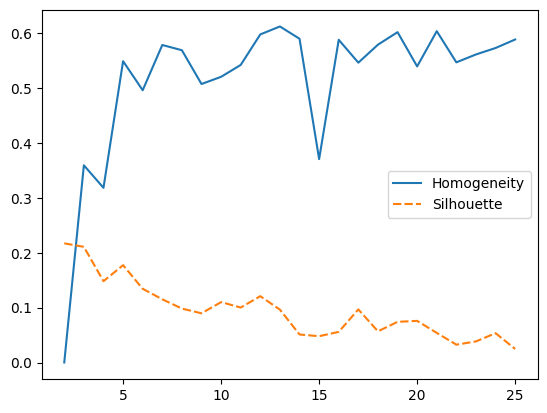

In [28]:
#Now for ICA
#revisit clustering

#EM
#EM PCA for rice
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = rice_ica_df_d3.drop('Class', inplace=False, axis=1).values.transpose().astype('float64'), rice_ica_df_d3['Class'] 
score_k = []
max_llh = []
for k in range(2, 26):
    em = eng.mixGaussEm(X, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y.values, labels)
    silhouette = metrics.silhouette_score(X.transpose(), labels)
    score_k.append((homogeneity, silhouette))
    max_llh.append(llh)

score_k = pd.DataFrame(score_k, index=range(2, 26), columns=['Homogeneity', 'Silhouette'])
max_llh = np.array(max_llh)
sns.lineplot(score_k)

EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
    SC Homogeneity  SC Silhouette  EM Homogeneity  EM Silhouette
2         0.554583       0.331282        0.001315       0.113310
3         0.554583       0.331282        0.002605       0.065249
4         0.554583   

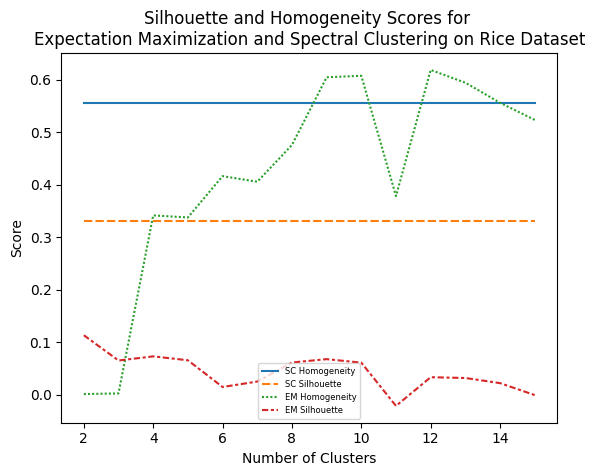

In [241]:

eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = rice_pca_df.drop('Class', axis=1, inplace=False), rice_pca_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_em = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
for k in range(2, 16):
    em = eng.mixGaussEm(X_em, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train['Class'], labels)
    silhouette = metrics.silhouette_score(X_train, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])

spectral_homogeneity = []
spectral_silhouette = []

for k in range(2, 16):
    labels = SpectralClustering(n_clusters=3, random_state=123).fit_predict(X_train)
    print(labels)
    spectral_homogeneity.append(homogeneity_score(y_train, labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['SC Homogeneity'] = spectral_homogeneity
initial_clustering_scores['SC Silhouette'] = spectral_silhouette
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=6)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Rice Dataset')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')
print(initial_clustering_scores)

EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
    EM Homogeneity  EM Silhouette
2         0.596599       0.373442
3         0.609471       0.354952
4         0.628045       0.251790
5         0.624043       0.258425
6         0.633747       0.208737
7         0.634750       0.224884
8         0.598910       0.224433
9         0.619199       0.254586
10        0.624671       0.199140
11        0.644052       0.119137
12        0.613254       0.279964
13        0.638203       0.086633
14        0.639917       0

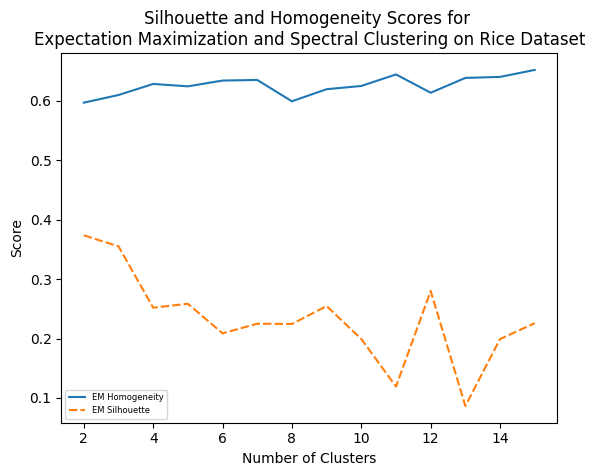

In [244]:
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = rice_ica_df.drop('Class', axis=1, inplace=False), rice_ica_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_em = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
for k in range(2, 16):
    em = eng.mixGaussEm(X_em, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train.values, labels)
    silhouette = metrics.silhouette_score(X_train, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])

spectral_homogeneity = []
spectral_silhouette = []

for k in range(2, 16):
    labels = SpectralClustering(n_clusters=3, random_state=123).fit_predict(X_train)
    spectral_homogeneity.append(homogeneity_score(y_train, labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=6)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Rice Dataset')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')
print(initial_clustering_scores)

In [ ]:
#EM for rice
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = rice_pca_df.drop('Class', axis=1, inplace=False), rice_pca_df['Class']
X = (X - X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
for k in range(2, 16):
    em = eng.mixGaussEm(X_train, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train.values, labels)
    silhouette = metrics.silhouette_score(X_train.T, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])
    
spectral_homogeneity = []
spectral_silhouette = []
for n in range(2, 16):
    labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X_train)
    spectral_homogeneity.append(homogeneity_score(y_train.values, labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['SC Homogeneity'] = spectral_homogeneity
initial_clustering_scores['SC Silhouette'] = spectral_silhouette
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=6)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Rice Dataset')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')

In [263]:
#EM for rice
print(rice_pca_df)


X, y = rice_rp_df_d3.drop('Class', axis=1, inplace=False), rice_rp_df_d3['Class']
X = (X - X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
print(y_train)

eng = matlab.engine.start_matlab()
eng.cd('../')
for k in range(2, 16):
    em = eng.mixGaussEm(X_train, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train.values, labels)
    silhouette = metrics.silhouette_score(X_train.T, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])

          pca0      pca1      pca2  Class
0     2.873213 -0.990462 -0.555539      1
1    -2.632510  0.173357  0.075960      0
2     0.033133 -1.868180 -0.730862      0
3    -1.324538  0.744098 -1.017807      0
4    -0.828347  1.468461 -1.298138      0
...        ...       ...       ...    ...
3043 -0.345978  0.964524 -1.051349      0
3044 -0.232810  1.454506  0.397890      0
3045 -2.227872 -0.490550 -0.931567      0
3046  3.799408  0.316335 -0.707350      1
3047  0.056203  1.805743  1.164942      0

[3048 rows x 4 columns]
2915    1
2095    0
169     0
1263    0
134     1
       ..
1156    0
2305    0
2545    0
572     1
1224    1
Name: Class, Length: 2438, dtype: int64
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian m

In [264]:
X, y = rice_pca_df.drop('Class', axis=1, inplace=False), rice_pca_df['Class']
X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
spectral_homogeneity = []
spectral_silhouette = []
for n in range(2, 16):
    labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X_train)
    spectral_homogeneity.append(homogeneity_score(y_train.values, labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

Text(0, 0.5, 'Score')

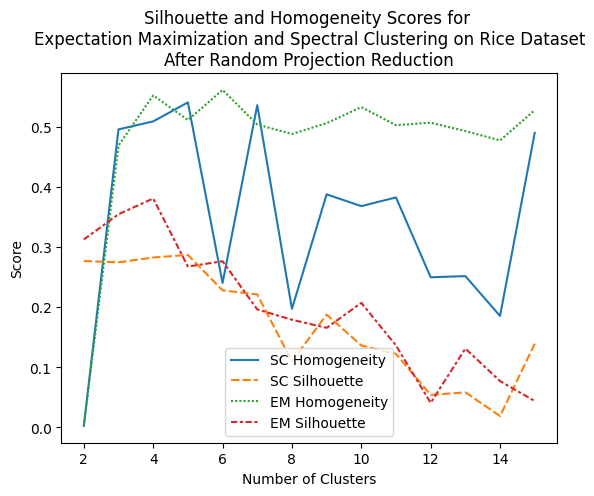

In [268]:
initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['SC Homogeneity'] = spectral_homogeneity
initial_clustering_scores['SC Silhouette'] = spectral_silhouette
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=10)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Rice Dataset\nAfter Random Projection Reduction')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')

In [ ]:
labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X_train)
spectral_homogeneity.append(homogeneity_score(y_train.values, labels))
spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

In [15]:
X, y = rice_mds_df_d3.drop('Class', axis=1, inplace=False), rice_mds_df_d3['Class']

eng = matlab.engine.start_matlab()
eng.cd('../')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
em = eng.mixGaussEm(X.values.transpose().astype('float64'), float(5), nargout=3)
labels = np.array(em[0])[0]

EM for Gaussian mixture: running ... 


In [24]:
X_train
mds_em_df = X.copy(deep=True)
mds_em_df['cluster'] = labels
mds_em_df['Class'] = y.values

mds_em_df.to_csv('mds_em.csv')

In [27]:
labels = SpectralClustering(n_clusters=5, random_state=123).fit_predict(X)
mds_sc_df = X.copy(deep=True)
mds_sc_df['cluster'] = labels
mds_sc_df['Class'] = y.values

mds_sc_df.to_csv('mds_sc.csv')